In [1]:
import numpy as np
import glob
from lb3d_checkpoint_io import *
import copy
import os

import sys

In [2]:
"""
Copy a simulation box containing a droplet along the z-direction.

This script copies a simulation box with a droplet centered in the middle of the domain,
extending it in the z-direction. It supports slicing of the box in the z-direction to
control the vertical spacing between droplets. Uses functions in the `lb3d_checkpoint.py` module.

Parameters
----------
path : str
    Directory of checkpoint files to copy.

nx : int
    Box size in the x-direction.

ny : int
    Box size in the y-direction.

nz : int
    Box size in the z-direction.

Q : int
    Number of dimensions in the LBM simulation. Defaults to 19.    

timestep : int
    Timestep of the simulation checkpoint to copy.

nprocs : int
    Number of processes used in the generation of the checkpoints to be copied.

gr_out : str
    Identity (prefix) of the new checkpoint files to be written.

join_cut : int
    Distance (in lattice units) to be removed from the center of the extended simulation domain.
    This controls how far apart the duplicated droplets are. A value of 0 duplicates the box as is;
    increasing values reduce the distance between droplets.

other_cut : int
    Distance (in lattice units) to be removed from the sides of the extended simulation domain.
    This controls how close the droplets are to the periodic domain of the box. A value of 0 keeps
    the droplets spaced the same distance from the side of the box as the input. Increasing values reduce
    the distance to the side of the periodic domain.

Returns
-------
None
    Writes new checkpoint files to disk with the updated domain size and duplicated droplets in the folder with variable name output_path
"""

'\nCopy a simulation box containing a droplet along the z-direction.\n\nThis script copies a simulation box with a droplet centered in the middle of the domain,\nextending it in the z-direction. It supports slicing of the box in the z-direction to\ncontrol the vertical spacing between droplets. Uses functions in the `lb3d_checkpoint.py` module.\n\nParameters\n----------\npath : str\n    Directory of checkpoint files to copy.\n\nnx : int\n    Box size in the x-direction.\n\nny : int\n    Box size in the y-direction.\n\nnz : int\n    Box size in the z-direction.\n\nQ : int\n    Number of dimensions in the LBM simulation. Defaults to 19.    \n\ntimestep : int\n    Timestep of the simulation checkpoint to copy.\n\nnprocs : int\n    Number of processes used in the generation of the checkpoints to be copied.\n\ngr_out : str\n    Identity (prefix) of the new checkpoint files to be written.\n\njoin_cut : int\n    Distance (in lattice units) to be removed from the center of the extended simulat

In [3]:
## EDIT THIS ONLY ##
# if len(sys.argv) > 1:
#     path = sys.argv[1]
#     nx = int(sys.argv[2])
#     ny = int(sys.argv[3])
#     nz = int(sys.argv[4])
#     timestep = int(sys.argv[5])
#     nprocs = int(sys.argv[6])
#     join_cut = int(sys.argv[7])
#     other_cut = int(sys.argv[8])

path = "droplet_checkpoints/templates/Ro_10-Rp_5-np_144"
nx, ny, nz = [256, 256, 512]
Q = 19
timestep = 1000000
nprocs = 128
Rp_old = 5
Ro_old = 10
npart = 144
rhof = 0.7

gr_out = "template"
Rp_new = 14.1
Ro_new = 7.1
## EDIT THIS ONLY ##

output_path = f"{path}/templates/Ro_{Ro_new}-Rp_{Rp_new}-np_{npart}"
os.makedirs(output_path, exist_ok=True)

In [ ]:
## READING OLD CHECKPOINTS ##
checkparams_files = sorted(glob.glob(f"{path}/checkparams*{timestep:08d}*.xdr"))[0]
fluid_checkpoint_files = sorted(glob.glob(f"{path}/checkpoint*{timestep:08d}*.xdr"))
checktopo_files = sorted(glob.glob(f"{path}/checktopo*{timestep:08d}*.xdr"))[0]
md_checkpoint_files = sorted(glob.glob(f"{path}/md-checkpoint*{timestep:08d}*.xdr"))[0]

curr_check_params = read_checkparams_xdr(checkparams_files)
curr_topo = read_checktopo_xdr(checktopo_files, nprocs = nprocs)
curr_fluid_params = read_checkpoint_xdr(fluid_checkpoint_files, nx, ny, nz, curr_topo, Q)
curr_md_params = read_md_checkpoint_xdr(md_checkpoint_files, use_rotation=True, interaction="ladd", n_spec = 2)
print("Checkpoints to be copied have been read")
## READING OLD CHECKPOINTS ##

Checkpoints to be copied have been read


# Fluid files

In [5]:
# ## FLUID CHECKPOINT FILE ##
new_fluid_params = curr_fluid_params.copy()
print("New fluid checkpoint file generated")
# ## FLUID CHECKPOINT FILE ##

New fluid checkpoint file generated


# MD Files

In [ ]:
## MD CHECKPOINT FILE ##
new_md_params = copy.deepcopy(curr_md_params)

# new_particles = [] 
# n = len(new_md_params["particles"])
new_particles = new_md_params["particles"]

## mass correction scheme also needs to be adjusted. 
ladd_data = new_md_params['ladd_data']
mass_target = np.array(ladd_data["global_mass_target"])
new_ladd_data = copy.deepcopy(ladd_data)

## TECHNIQUE 3: Calculating mass of box components after slicing ##
old_particle_masses = 4/3*np.pi*Ro_old*Ro_old*Rp_old*npart*rhof
new_particle_masses = 4/3*np.pi*Ro_new*Ro_new*Rp_new*npart*rhof
particle_masses = new_particle_masses# - old_particle_masses
new_target_mass = np.array([np.sum(new_fluid_params[..., :Q])/curr_check_params['taubulk_r'], np.sum(new_fluid_params[..., Q:2*Q])/curr_check_params['taubulk_b']])
new_target_mass -= particle_masses/4
new_ladd_data["global_mass_target"] = new_target_mass
## TECHNIQUE 3: Calculating mass of box components after slicing ##

new_md_params['ladd_data'] = new_ladd_data
print("New MD checkpoint file generated")
## MD CHECKPOINT FILE ##

New MD checkpoint file generated


# Output

In [ ]:
## OUTPUTTING NEW CHECKPOINTS ##
uid = np.random.randint(0, 2**31, 1)[0] # Generating random number of a signed FP32 integer

checkparams_file_template = "checkparams_{0}_t{1:08d}-{2:010d}.xdr"
fluid_checkpoint_file_template = "checkpoint_{0}_t{1:08d}-{2:010d}_p{3:06d}.xdr"
checktopo_file_template = "checktopo_{0}_t{1:08d}-{2:010d}.xdr"
md_checkpoint_file_template = "md-checkpoint_{0}_t{1:08d}-{2:010d}.xdr"

# output_params_path = output_path + "/" + checkparams_file_template.format(gr_out, timestep, uid)
# output_fluid_path = output_path + "/" + fluid_checkpoint_file_template.format(gr_out, timestep, uid, 0)
# output_topo_path = output_path + "/" + checktopo_file_template.format(gr_out, timestep, uid)
output_md_check_path = output_path + "/" + md_checkpoint_file_template.format(gr_out, timestep, uid)

# write_checkparams_xdr(output_params_path, new_check_params)
# write_checkpoint_xdr(output_fluid_path, new_fluid_params, nx, ny, 2*(nz - join_cut - other_cut))
# write_checktopo_xdr(output_topo_path, new_topo)
write_md_checkpoint_xdr(output_md_check_path, new_md_params["particles"], 
                        use_rotation=True, steps_per_lbe_step=1, interaction="ladd",
                        ladd_props=new_md_params['ladd_data'],
                        n_spec=2)

print(f"Checkpoint output successful!. UID:{uid}")
## OUTPUTTING NEW CHECKPOINTS ##

Checkpoint output successful!. UID:1873612666


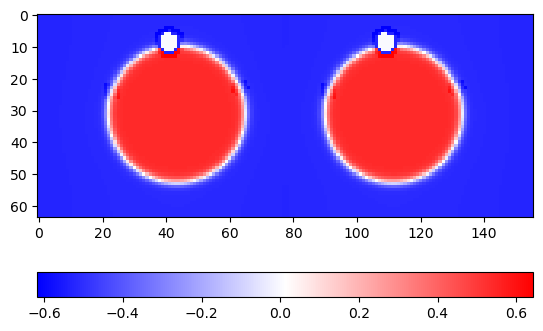

In [ ]:
# import matplotlib.pyplot as plt

# new_topo = read_checktopo_xdr(output_topo_path)
# test = read_checkpoint_xdr([output_fluid_path], nx, ny, 2*(nz - join_cut - other_cut), new_topo)

# tiled_phi = np.sum(test[..., :Q], axis = -1) - np.sum(test[..., Q:2*Q], axis = -1)
# plt.imshow(tiled_phi[:, ny//2, :], cmap = 'bwr')
# plt.colorbar(orientation = "horizontal")

In [11]:
tiled_phi.shape

(64, 64, 156)